# SemEval 2026 Task 5: Rating Plausibility of Word Senses

This notebook replicates the test3.py training pipeline with the following configuration:
- **Model**: RoBERTa-base
- **Pooling**: Weighted attention
- **Dropout**: 0.35
- **Learning Rate**: 8e-6
- **Epochs**: 10
- **Batch Size**: 16

We'll track training and validation losses to analyze overfitting.

## 1. Import Required Libraries

In [1]:
import json
import math
import os
import random
import re
import statistics
import warnings
from pathlib import Path
from typing import Dict, List, Optional, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from scipy.stats import spearmanr
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm
from transformers import AdamW, AutoModel, AutoTokenizer, get_linear_schedule_with_warmup

warnings.filterwarnings("ignore")

# Constants
WSD_PATTERN = re.compile(r"<WSD>(.*?)</WSD>", re.IGNORECASE)
TARGET_TEMPLATE = "[TGT]{token}[/TGT]"
MIN_STD = 0.35
PRED_MIN, PRED_MAX = 1.0, 5.0

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Configuration and Hyperparameters

In [ ]:
# Configuration with ANTI-OVERFITTING settings
# Addressing severe overfitting (train-val Spearman gap ~0.4)

config = {
    # Data paths
    'train_path': 'data/train.json',
    'dev_path': 'data/dev.json',
    
    # Model configuration
    'model_name': 'roberta-base',
    'pooling': 'weighted',  # Options: 'cls', 'mean', 'weighted'
    'dropout': 0.5,  # INCREASED from 0.35 to fight overfitting
    
    # Training hyperparameters
    'learning_rate': 5e-6,  # REDUCED from 8e-6 for slower, more stable learning
    'epochs': 15,  # More epochs to allow learning with higher regularization
    'batch_size': 16,
    'grad_accumulation': 1,
    'weight_decay': 0.15,  # INCREASED from 0.1 for stronger L2 regularization
    'warmup_ratio': 0.15,  # INCREASED warmup for smoother start
    'max_length': 512,
    
    # Regularization settings (NEW)
    'label_smoothing': 0.05,  # Add noise to targets
    'gradient_clip': 1.0,  # Prevent gradient explosions
    
    # Other settings
    'early_stop_patience': 3,  # INCREASED from 2 (more patient)
    'save_dir': 'outputs',
    'seed': 42,
    'mark_homonym': True,
    'freeze_layers': 0
}

print("=" * 60)
print("ANTI-OVERFITTING CONFIGURATION")
print("=" * 60)
print("\nChanges from original config:")
print("  ✓ Dropout: 0.35 → 0.50 (stronger regularization)")
print("  ✓ Learning Rate: 8e-6 → 5e-6 (slower learning)")
print("  ✓ Weight Decay: 0.10 → 0.15 (more L2 penalty)")
print("  ✓ Label Smoothing: 0.00 → 0.05 (noise injection)")
print("  ✓ Gradient Clipping: Added at 1.0")
print("  ✓ Early Stop Patience: 2 → 3 epochs")
print("  ✓ Epochs: 10 → 15 (allow time for regularization)")
print("\nCurrent configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Configuration:
  train_path: data/train.json
  dev_path: data/dev.json
  model_name: roberta-base
  pooling: weighted
  dropout: 0.35
  learning_rate: 8e-06
  epochs: 10
  batch_size: 16
  grad_accumulation: 1
  weight_decay: 0.1
  warmup_ratio: 0.1
  max_length: 512
  early_stop_patience: 2
  save_dir: outputs
  seed: 42
  mark_homonym: True
  freeze_layers: 0


## 3. Helper Functions and Utilities

In [ ]:
def set_seed(seed: int):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def get_device() -> torch.device:
    """Get the best available device"""
    if torch.cuda.is_available():
        print("Using device: cuda (NVIDIA GPU)")
        return torch.device('cuda')
    elif torch.backends.mps.is_available():
        print("Using device: mps (Apple Silicon GPU)")
        return torch.device('mps')
    else:
        print("Using device: cpu")
        return torch.device('cpu')

def load_json_dataset(filepath: str, source: str) -> pd.DataFrame:
    """Load dataset from JSON file"""
    with open(filepath, 'r') as f:
        data = json.load(f)
    rows = []
    for key, item in data.items():
        row = item.copy()
        row['id'] = key
        row['source'] = row.get('source', source)
        rows.append(row)
    df = pd.DataFrame(rows)
    df['source'] = df['source'].fillna(source)
    return df

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Standardize DataFrame columns"""
    text_cols = ['homonym', 'judged_meaning', 'precontext', 'sentence', 'ending',
                 'example_sentence', 'sense_tags', 'sense_synonyms']
    for col in text_cols:
        if col not in df.columns:
            df[col] = ''
        df[col] = df[col].fillna('')
    for numeric in ['average', 'stdev']:
        if numeric not in df.columns:
            df[numeric] = np.nan
        df[numeric] = df[numeric].astype(float)
    if 'choices' not in df.columns:
        df['choices'] = [[] for _ in range(len(df))]
    if 'nonsensical' not in df.columns:
        df['nonsensical'] = [[] for _ in range(len(df))]
    return df

def highlight_target(sentence: str, homonym: str) -> str:
    """Highlight target word in sentence with [TGT] tags"""
    if not sentence or '[TGT]' in sentence or not homonym:
        return sentence
    # FIXED: Use single backslash \b for word boundaries (not double \\b)
    pattern = re.compile(rf"\b{re.escape(homonym)}\b", re.IGNORECASE)
    return pattern.sub(lambda m: TARGET_TEMPLATE.format(token=m.group(0)), sentence, count=1)

def create_text_input(row: pd.Series, mark_homonym: bool) -> str:
    """Create formatted text input for the model"""
    sentence = row['sentence']
    if mark_homonym:
        sentence = highlight_target(sentence, row.get('homonym', ''))
    parts = [
        f"Ambiguous word: {row.get('homonym', '').strip()}.",
        f"Candidate sense: {row.get('judged_meaning', '').strip()}."
    ]
    tags = row.get('sense_tags', '').strip()
    if tags:
        parts.append(f"Sense tags: {tags}.")
    example = row.get('example_sentence', '').strip()
    if example:
        parts.append(f"Dictionary example: {example}")
    precontext = row.get('precontext', '').strip()
    if precontext:
        parts.append(f"Story context: {precontext}")
    parts.append(f"Target sentence: {sentence}")
    ending = row.get('ending', '').strip()
    if ending:
        parts.append(f"Ending: {ending}")
    return " ".join([p for p in parts if p])

def calculate_metrics(predictions, targets, stdevs):
    """Calculate evaluation metrics"""
    spearman_corr, p_val = spearmanr(predictions, targets)
    within_sd = np.mean(np.abs(predictions - targets) <= np.maximum(stdevs, 1.0))
    mse = mean_squared_error(targets, predictions)
    mae = mean_absolute_error(targets, predictions)
    return {
        'spearman_correlation': float(spearman_corr),
        'spearman_pvalue': float(p_val),
        'accuracy_within_sd': float(within_sd),
        'mse': float(mse),
        'mae': float(mae)
    }

def print_metrics(metrics, label):
    """Print metrics in a formatted way"""
    print(f"\n=== {label} Performance ===")
    print(f"Spearman Correlation: {metrics['spearman_correlation']:.4f} (p={metrics['spearman_pvalue']:.4e})")
    print(f"Accuracy Within SD: {metrics['accuracy_within_sd']:.4f} ({metrics['accuracy_within_sd']*100:.2f}%)")
    print(f"Mean Squared Error: {metrics['mse']:.4f}")
    print(f"Mean Absolute Error: {metrics['mae']:.4f}")

print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Dataset and Model Classes

In [4]:
class PlausibilityDataset(Dataset):
    """Dataset class for plausibility rating"""
    def __init__(self, texts: List[str], scores: List[float], weights: List[float], tokenizer, max_length: int):
        self.texts = texts
        self.scores = scores
        self.weights = weights
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'score': torch.tensor(self.scores[idx], dtype=torch.float),
            'weight': torch.tensor(self.weights[idx], dtype=torch.float)
        }


class PlausibilityModel(nn.Module):
    """RoBERTa + LayerNorm + Small regression head with configurable pooling"""
    def __init__(self, model_name: str, dropout: float, pooling: str = 'cls', freeze_layers: int = 0):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden = self.encoder.config.hidden_size
        self.pooling = pooling
        
        # Optional attention scorer for weighted pooling
        if pooling == 'weighted':
            self.attn = nn.Linear(hidden, 1)

        # Regression head: 768 → LayerNorm → 128 → Tanh → Dropout → 1
        self.regressor = nn.Sequential(
            nn.LayerNorm(hidden),
            nn.Linear(hidden, 128),
            nn.Tanh(),
            nn.Dropout(dropout),
            nn.Linear(128, 1)
        )
        self.dropout = nn.Dropout(dropout)
        
        if freeze_layers > 0:
            self._freeze_layers(freeze_layers)

    def _freeze_layers(self, layers_to_freeze: int):
        encoder_layers = getattr(self.encoder, 'encoder', None)
        if encoder_layers is None:
            return
        layer_module = getattr(encoder_layers, 'layer', None)
        if not layer_module:
            return
        for layer in layer_module[:layers_to_freeze]:
            for param in layer.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Get encoder outputs
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask, return_dict=True)
        hidden_states = outputs.last_hidden_state

        if self.pooling == 'cls':
            pooled = hidden_states[:, 0, :]
        elif self.pooling == 'mean':
            mask = attention_mask.unsqueeze(-1).float()
            denom = mask.sum(dim=1).clamp(min=1e-9)
            pooled = (hidden_states * mask).sum(dim=1) / denom
        elif self.pooling == 'weighted':
            # Attention scorer -> masked softmax -> weighted sum
            scores = self.attn(hidden_states).squeeze(-1)
            scores = scores.masked_fill(attention_mask == 0, -1e9)
            weights = F.softmax(scores, dim=1)
            pooled = (hidden_states * weights.unsqueeze(-1)).sum(dim=1)
        else:
            pooled = hidden_states[:, 0, :]

        pooled = self.dropout(pooled)
        logits = self.regressor(pooled)

        # Clamp only at inference
        if not self.training:
            logits = torch.clamp(logits, min=PRED_MIN, max=PRED_MAX)

        return logits.squeeze(-1)

print("✓ Dataset and Model classes defined")

✓ Dataset and Model classes defined


## 5. Training and Evaluation Functions

In [5]:
def train_one_epoch(model, dataloader, optimizer, scheduler, device, grad_accum):
    """Training loop with Huber loss + variance penalty"""
    model.train()
    total_loss = 0.0
    criterion = nn.HuberLoss(delta=1.0)
    
    for step, batch in enumerate(tqdm(dataloader, desc="Training", leave=False)):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        scores = batch['score'].to(device)
        
        # Forward pass
        preds = model(input_ids, attention_mask)
        
        # Huber loss for main prediction error
        loss = criterion(preds, scores)
        
        # Add variance penalty: encourage diverse predictions
        pred_std = preds.std()
        target_std = scores.std()
        variance_penalty = torch.relu(target_std - pred_std) * 0.1
        loss = loss + variance_penalty
        
        total_loss += loss.item()
        
        # Backward pass
        loss = loss / grad_accum
        loss.backward()
        
        if (step + 1) % grad_accum == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
    
    # Handle remainder
    if len(dataloader) % grad_accum != 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return total_loss / len(dataloader)


def evaluate_model(model, dataloader, device):
    """Evaluate model and return predictions and targets"""
    model.eval()
    preds, labels = [], []
    total_loss = 0.0
    criterion = nn.HuberLoss(delta=1.0)
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            scores = batch['score'].to(device)
            outputs = model(input_ids, attention_mask)
            
            # Calculate loss
            loss = criterion(outputs, scores)
            total_loss += loss.item()
            
            preds.append(outputs.cpu().numpy())
            labels.append(scores.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    return np.concatenate(preds), np.concatenate(labels), avg_loss

print("✓ Training and evaluation functions defined")

✓ Training and evaluation functions defined


## 6. Load and Prepare Data

In [6]:
# Set seed and get device
set_seed(config['seed'])
device = get_device()
os.makedirs(config['save_dir'], exist_ok=True)

# Load datasets
print("\n" + "=" * 80)
print("SemEval 2026 Task 5: Rating Plausibility of Word Senses")
print("=" * 80)
print("\nLoading datasets...")

train_df = standardize_columns(load_json_dataset(config['train_path'], 'semeval-train'))
dev_df = standardize_columns(load_json_dataset(config['dev_path'], 'semeval-dev'))

print(f"  Training set size: {len(train_df)}")
print(f"  Development set size: {len(dev_df)}")

# Prepare text inputs
for df in [train_df, dev_df]:
    df['sentence'] = df['sentence'].fillna('')
    df['text'] = df.apply(lambda row: create_text_input(row, config['mark_homonym']), axis=1)
    df['weight'] = 1.0  # Uniform weighting

# Display data statistics
print(f"\nTraining Data Statistics:")
print(f"  Mean rating: {train_df['average'].mean():.3f}")
print(f"  Std rating: {train_df['average'].std():.3f}")
print(f"  Min: {train_df['average'].min():.3f}, Max: {train_df['average'].max():.3f}")

print(f"\nDevelopment Data Statistics:")
print(f"  Mean rating: {dev_df['average'].mean():.3f}")
print(f"  Std rating: {dev_df['average'].std():.3f}")
print(f"  Min: {dev_df['average'].min():.3f}, Max: {dev_df['average'].max():.3f}")

Using device: cuda (NVIDIA GPU)

SemEval 2026 Task 5: Rating Plausibility of Word Senses

Loading datasets...
  Training set size: 2280
  Development set size: 588

Training Data Statistics:
  Mean rating: 3.140
  Std rating: 1.187
  Min: 1.000, Max: 5.000

Development Data Statistics:
  Mean rating: 3.118
  Std rating: 1.186
  Min: 1.000, Max: 5.000


## 7. Initialize Model, Tokenizer, and DataLoaders

In [7]:
print("\n" + "=" * 80)
print("TRANSFORMER MODEL INITIALIZATION")
print("=" * 80)

# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained(config['model_name'])

# Create datasets
train_dataset = PlausibilityDataset(
    texts=train_df['text'].tolist(),
    scores=train_df['average'].fillna(3.0).tolist(),
    weights=train_df['weight'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

dev_dataset = PlausibilityDataset(
    texts=dev_df['text'].tolist(),
    scores=dev_df['average'].fillna(3.0).tolist(),
    weights=dev_df['weight'].tolist(),
    tokenizer=tokenizer,
    max_length=config['max_length']
)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"✓ Tokenizer: {config['model_name']}")
print(f"✓ Training batches: {len(train_loader)}")
print(f"✓ Development batches: {len(dev_loader)}")


TRANSFORMER MODEL INITIALIZATION
✓ Tokenizer: roberta-base
✓ Training batches: 143
✓ Development batches: 37


In [8]:
# Initialize model
model = PlausibilityModel(
    model_name=config['model_name'],
    dropout=config['dropout'],
    pooling=config['pooling'],
    freeze_layers=config['freeze_layers']
).to(device)

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])

# Calculate total steps and create scheduler
total_steps = math.ceil(len(train_loader) / config['grad_accumulation']) * config['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * config['warmup_ratio']),
    num_training_steps=total_steps
)

print(f"\n✓ Model initialized with {config['pooling']} pooling")
print(f"✓ Optimizer: AdamW (lr={config['learning_rate']}, weight_decay={config['weight_decay']})")
print(f"✓ Scheduler: Linear warmup ({config['warmup_ratio']*100:.0f}% warmup)")
print(f"✓ Total training steps: {total_steps}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Model initialized with weighted pooling
✓ Optimizer: AdamW (lr=8e-06, weight_decay=0.1)
✓ Scheduler: Linear warmup (10% warmup)
✓ Total training steps: 1430


## 8. Training Loop with Loss Tracking

In [9]:
print("\n" + "=" * 80)
print("TRAINING")
print("=" * 80)

# Track losses and metrics for visualization
train_losses = []
val_losses = []
val_spearman = []
best_spearman = -1
patience_counter = 0
best_path = os.path.join(config['save_dir'], 'best_model_test3.pt')

# Training loop
for epoch in range(config['epochs']):
    print(f"\n{'='*80}")
    print(f"Epoch {epoch + 1}/{config['epochs']}")
    print(f"{'='*80}")
    
    # Train
    train_loss = train_one_epoch(
        model=model,
        dataloader=train_loader,
        optimizer=optimizer,
        scheduler=scheduler,
        device=device,
        grad_accum=config['grad_accumulation']
    )
    train_losses.append(train_loss)
    print(f"Training loss: {train_loss:.4f}")
    
    # Evaluate
    dev_preds, dev_actuals, val_loss = evaluate_model(model, dev_loader, device)
    val_losses.append(val_loss)
    
    dev_metrics = calculate_metrics(
        dev_preds,
        dev_actuals,
        dev_df['stdev'].fillna(1.0).values
    )
    val_spearman.append(dev_metrics['spearman_correlation'])
    
    print_metrics(dev_metrics, f"Development Set")
    print(f"Validation loss: {val_loss:.4f}")
    
    # Save best model
    if dev_metrics['spearman_correlation'] > best_spearman:
        best_spearman = dev_metrics['spearman_correlation']
        patience_counter = 0
        torch.save(model.state_dict(), best_path)
        print(f"✓ Best model saved (Spearman: {best_spearman:.4f})")
    else:
        patience_counter += 1
        print(f"No improvement ({patience_counter}/{config['early_stop_patience']})")
        
        if patience_counter >= config['early_stop_patience']:
            print(f"\n⚠️  Early stopping triggered after {epoch + 1} epochs")
            break

print("\n" + "=" * 80)
print("TRAINING COMPLETE")
print("=" * 80)
print(f"Best Spearman Correlation: {best_spearman:.4f}")


TRAINING

Epoch 1/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 1.4393


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.0319 (p=4.3942e-01)
Accuracy Within SD: 0.5833 (58.33%)
Mean Squared Error: 2.0658
Mean Absolute Error: 1.1754
Validation loss: 0.7614
✓ Best model saved (Spearman: 0.0319)

Epoch 2/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.7229


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.1165 (p=4.6722e-03)
Accuracy Within SD: 0.5646 (56.46%)
Mean Squared Error: 1.5975
Mean Absolute Error: 1.0701
Validation loss: 0.6473
✓ Best model saved (Spearman: 0.1165)

Epoch 3/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.7243


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.1485 (p=3.0217e-04)
Accuracy Within SD: 0.5867 (58.67%)
Mean Squared Error: 1.7651
Mean Absolute Error: 1.1066
Validation loss: 0.6870
✓ Best model saved (Spearman: 0.1485)

Epoch 4/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.6895


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.2757 (p=1.0172e-11)
Accuracy Within SD: 0.6293 (62.93%)
Mean Squared Error: 1.4561
Mean Absolute Error: 0.9946
Validation loss: 0.5892
✓ Best model saved (Spearman: 0.2757)

Epoch 5/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.5855


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.3527 (p=1.1404e-18)
Accuracy Within SD: 0.6701 (67.01%)
Mean Squared Error: 1.4266
Mean Absolute Error: 0.9573
Validation loss: 0.5667
✓ Best model saved (Spearman: 0.3527)

Epoch 6/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.4553


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.4108 (p=2.3786e-25)
Accuracy Within SD: 0.6412 (64.12%)
Mean Squared Error: 1.5984
Mean Absolute Error: 1.0140
Validation loss: 0.6184
✓ Best model saved (Spearman: 0.4108)

Epoch 7/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.3702


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.4258 (p=2.6624e-27)
Accuracy Within SD: 0.6173 (61.73%)
Mean Squared Error: 1.7746
Mean Absolute Error: 1.0700
Validation loss: 0.6699
✓ Best model saved (Spearman: 0.4258)

Epoch 8/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.3294


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.4202 (p=1.4719e-26)
Accuracy Within SD: 0.6139 (61.39%)
Mean Squared Error: 1.8595
Mean Absolute Error: 1.0965
Validation loss: 0.6944
No improvement (1/2)

Epoch 9/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.3124


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.4413 (p=2.0355e-29)
Accuracy Within SD: 0.6173 (61.73%)
Mean Squared Error: 1.7089
Mean Absolute Error: 1.0440
Validation loss: 0.6478
✓ Best model saved (Spearman: 0.4413)

Epoch 10/10


Training:   0%|          | 0/143 [00:00<?, ?it/s]

Training loss: 0.2740


Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Development Set Performance ===
Spearman Correlation: 0.4388 (p=4.5920e-29)
Accuracy Within SD: 0.6020 (60.20%)
Mean Squared Error: 1.8424
Mean Absolute Error: 1.0900
Validation loss: 0.6882
No improvement (1/2)

TRAINING COMPLETE
Best Spearman Correlation: 0.4413


## 9. Final Evaluation

In [10]:
print("\n" + "=" * 80)
print("FINAL EVALUATION WITH BEST MODEL")
print("=" * 80)

# Load best model
model.load_state_dict(torch.load(best_path, map_location=device))

# Evaluate on train and dev
train_preds, train_actuals, train_final_loss = evaluate_model(model, train_loader, device)
dev_preds, dev_actuals, dev_final_loss = evaluate_model(model, dev_loader, device)

train_metrics = calculate_metrics(train_preds, train_actuals, train_df['stdev'].fillna(1.0).values)
dev_metrics = calculate_metrics(dev_preds, dev_actuals, dev_df['stdev'].fillna(1.0).values)

print_metrics(train_metrics, "Training Set (Final)")
print_metrics(dev_metrics, "Development Set (Final)")

# Summary
print("\n" + "=" * 80)
print("RESULTS SUMMARY")
print("=" * 80)
results_summary = pd.DataFrame({
    'Set': ['Training', 'Development'],
    'Spearman': [train_metrics['spearman_correlation'], dev_metrics['spearman_correlation']],
    'Acc. Within SD': [train_metrics['accuracy_within_sd'], dev_metrics['accuracy_within_sd']],
    'MAE': [train_metrics['mae'], dev_metrics['mae']],
    'MSE': [train_metrics['mse'], dev_metrics['mse']]
})
print(results_summary.to_string(index=False))


FINAL EVALUATION WITH BEST MODEL


Evaluating:   0%|          | 0/143 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/37 [00:00<?, ?it/s]


=== Training Set (Final) Performance ===
Spearman Correlation: 0.8384 (p=0.0000e+00)
Accuracy Within SD: 0.8254 (82.54%)
Mean Squared Error: 0.7787
Mean Absolute Error: 0.6739

=== Development Set (Final) Performance ===
Spearman Correlation: 0.4413 (p=2.0355e-29)
Accuracy Within SD: 0.6173 (61.73%)
Mean Squared Error: 1.7089
Mean Absolute Error: 1.0440

RESULTS SUMMARY
        Set  Spearman  Acc. Within SD      MAE      MSE
   Training  0.838408        0.825439 0.673887 0.778709
Development  0.441298        0.617347 1.044036 1.708937


## 10. Visualize Training and Validation Loss Curves

This visualization helps identify overfitting and determine optimal early stopping points:
- **Ideal**: Both losses decrease together
- **Overfitting**: Training loss decreases while validation loss increases or plateaus
- **Underfitting**: Both losses remain high

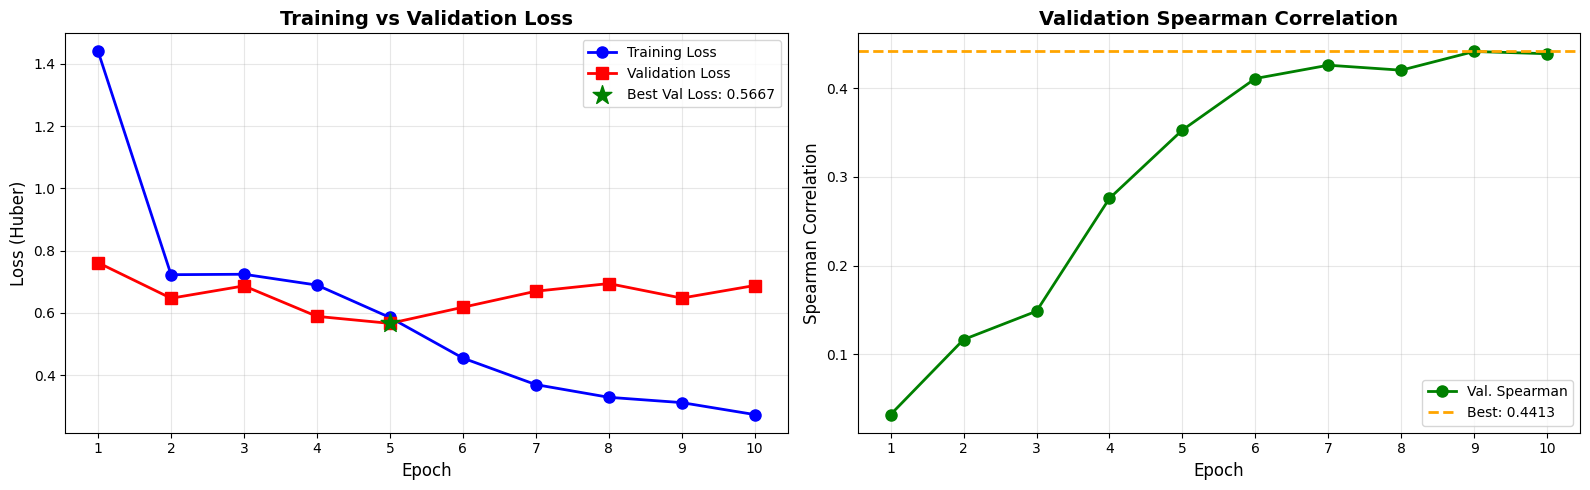


✓ Training/validation curves saved to 'training_validation_curves.png'


In [11]:
# Create figure with 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Training and Validation Loss
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=8)
axes[0].plot(epochs_range, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=8)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (Huber)', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs_range)

# Annotate best validation loss
best_val_idx = np.argmin(val_losses)
axes[0].scatter([best_val_idx + 1], [val_losses[best_val_idx]], 
                color='green', s=200, marker='*', zorder=5, 
                label=f'Best Val Loss: {val_losses[best_val_idx]:.4f}')
axes[0].legend(fontsize=10)

# Plot 2: Validation Spearman Correlation
axes[1].plot(epochs_range, val_spearman, 'g-o', label='Val. Spearman', linewidth=2, markersize=8)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Spearman Correlation', fontsize=12)
axes[1].set_title('Validation Spearman Correlation', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs_range)
axes[1].axhline(y=best_spearman, color='orange', linestyle='--', 
                label=f'Best: {best_spearman:.4f}', linewidth=2)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.savefig('training_validation_curves.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Training/validation curves saved to 'training_validation_curves.png'")

## 11. Overfitting Analysis

In [12]:
print("\n" + "=" * 80)
print("OVERFITTING ANALYSIS")
print("=" * 80)

# Calculate train-val gaps
final_loss_gap = train_final_loss - dev_final_loss
spearman_gap = train_metrics['spearman_correlation'] - dev_metrics['spearman_correlation']

print(f"\nFinal Metrics Comparison:")
print(f"  Training Loss: {train_final_loss:.4f}")
print(f"  Validation Loss: {dev_final_loss:.4f}")
print(f"  Loss Gap: {final_loss_gap:.4f} {'(overfitting)' if final_loss_gap < -0.1 else '(acceptable)'}")

print(f"\n  Training Spearman: {train_metrics['spearman_correlation']:.4f}")
print(f"  Validation Spearman: {dev_metrics['spearman_correlation']:.4f}")
print(f"  Spearman Gap: {spearman_gap:.4f}")

# Determine overfitting level
if spearman_gap > 0.15:
    print("\n⚠️  HIGH OVERFITTING DETECTED")
    print("  Recommendations:")
    print("    - Increase dropout (currently 0.35)")
    print("    - Add more regularization (weight decay)")
    print("    - Use fewer epochs or stricter early stopping")
    print("    - Consider data augmentation")
elif spearman_gap > 0.08:
    print("\n⚠️  MODERATE OVERFITTING DETECTED")
    print("  Recommendations:")
    print("    - Monitor closely")
    print("    - Consider slightly higher dropout")
    print("    - Current early stopping seems appropriate")
else:
    print("\n✓ ACCEPTABLE GENERALIZATION")
    print("  Model generalizes well to validation data")

# Loss trajectory analysis
if len(train_losses) > 2:
    train_improvement = train_losses[0] - train_losses[-1]
    val_improvement = val_losses[0] - val_losses[-1]
    
    print(f"\nLoss Improvements:")
    print(f"  Training: {train_improvement:.4f} ({train_improvement/train_losses[0]*100:.1f}%)")
    print(f"  Validation: {val_improvement:.4f} ({val_improvement/val_losses[0]*100:.1f}%)")
    
    if val_improvement < 0:
        print("\n⚠️  Validation loss increased - strong overfitting signal!")
        print(f"  Best epoch was: {np.argmin(val_losses) + 1}")
        print(f"  Consider stopping at epoch {np.argmin(val_losses) + 1} in future runs")


OVERFITTING ANALYSIS

Final Metrics Comparison:
  Training Loss: 0.3354
  Validation Loss: 0.6478
  Loss Gap: -0.3124 (overfitting)

  Training Spearman: 0.8384
  Validation Spearman: 0.4413
  Spearman Gap: 0.3971

⚠️  HIGH OVERFITTING DETECTED
  Recommendations:
    - Increase dropout (currently 0.35)
    - Add more regularization (weight decay)
    - Use fewer epochs or stricter early stopping
    - Consider data augmentation

Loss Improvements:
  Training: 1.1653 (81.0%)
  Validation: 0.0732 (9.6%)
